# DeepSurv Example

GitHub: https://github.com/huangyuzhang/cookbook/blob/master/survival_analysis/example_DeepSurv.ipynb

DeepSurv: https://github.com/jaredleekatzman/DeepSurv

In this notebook, I fixed some problems of installing the DeepSurv's dependencies and the importing the package & dataset globally.

In [ ]:
# DeepSurv requires a latest version of lasagne, run below to get the lasagne==0.2.dev1 first.
# source: https://lasagne.readthedocs.io/en/latest/user/installation.html#bleeding-edge-version
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
    
# install DeepSurv from source:
!git clone https://github.com/jaredleekatzman/DeepSurv.git DeepSurv
!pip install ./DeepSurv

In [1]:
# import DeepSurv
import sys
# sys.path.append('../deepsurv')
from deepsurv import deep_surv

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger
import deepsurv.utils
from deepsurv import viz

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot graphs in retina resolution
%config InlineBackend.figure_format = 'retina'

# Read in dataset
First, I read in the dataset and print the first five elements to get a sense of what the dataset looks like

In [2]:
dataset_fp = 'data/deepsurv_data.csv'
train_df = pd.read_csv(dataset_fp)
train_df.head()

,Variable_1,Variable_2,Variable_3,Variable_4,Event,Time
0,0,3,2,4.6,1,43
1,0,2,0,1.6,0,52
2,0,3,0,3.5,1,73
3,0,3,1,5.1,0,51
4,0,2,0,1.7,0,51


# Transform the dataset to "DeepSurv" format
DeepSurv expects a dataset to be in the form:

    {
        'x': numpy array of float32
        'e': numpy array of int32
        't': numpy array of float32
        'hr': (optional) numpy array of float32
    }
    
You are providing me a csv, which I read in as a pandas dataframe. Then I convert the pandas dataframe into the DeepSurv dataset format above. 

In [3]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col = 'Event', time_col= 'Time')

Now once you have your dataset all formatted, define you hyper_parameters as a Python dictionary. 
I'll provide you with some example hyper-parameters, but you should replace the values once you tune them to your specific dataset

In [4]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

Once you prepared your dataset, and defined your hyper-parameters. Now it's time to train DeepSurv!

In [5]:
# Create an instance of DeepSurv using the hyperparams defined above
model = deep_surv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'test_experiment_sebastian'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 2000

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)

2019-08-09 13:26:56,500 - Training step 0/2000    |                         | - loss: 25.4129 - ci: 0.6173
2019-08-09 13:27:35,824 - Training step 250/2000  |***                      | - loss: 13.5311 - ci: 0.6163
2019-08-09 13:28:01,502 - Training step 500/2000  |******                   | - loss: 8.5981 - ci: 0.6211
2019-08-09 13:28:22,560 - Training step 750/2000  |*********                | - loss: 7.0277 - ci: 0.6277
2019-08-09 13:28:45,520 - Training step 1000/2000 |************             | - loss: 6.4582 - ci: 0.6582
2019-08-09 13:29:07,031 - Training step 1250/2000 |***************          | - loss: 6.2730 - ci: 0.6894
2019-08-09 13:29:28,175 - Training step 1500/2000 |******************       | - loss: 6.2053 - ci: 0.7074
2019-08-09 13:29:49,846 - Training step 1750/2000 |*********************    | - loss: 6.1761 - ci: 0.7073
2019-08-09 13:30:11,516 - Finished Training with 2000 iterations in 195.19s


There are two different ways to visualzie how the model trained:

- Tensorboard (install ()[tensorboard]) which provides realtime metrics. Run the command in shell (notice to run it in the same folder of this notebook):
   
   `tensorboard --logdir './logs/tensorboard'`
     
     
- Visualize the training functions post training (below)

Train C-Index: (1999, 0.7064904028525909)


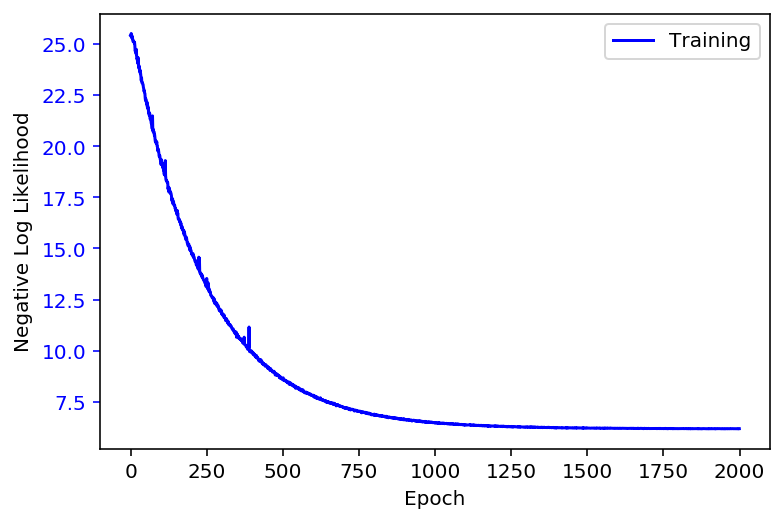

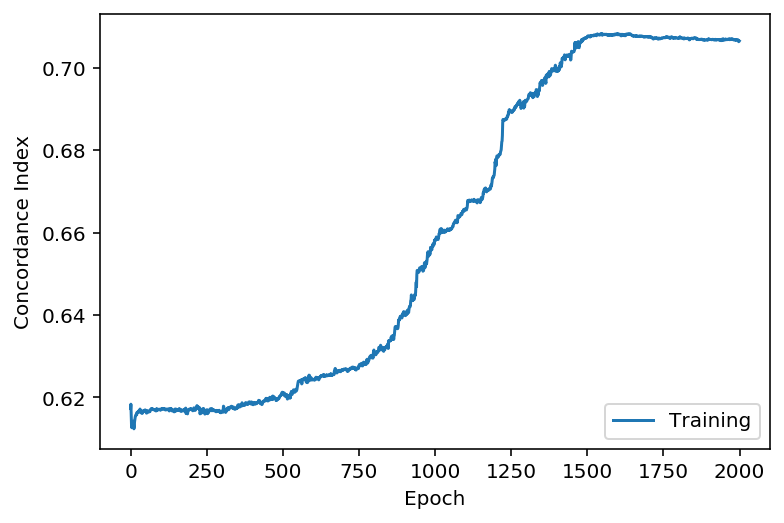

In [6]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)

In [8]:
# save trained model
model.save_model('bestparams.json', weights_file='bestweights.h5')

# load saved model
mode_load = deepsurv.deep_surv.load_model_from_json('bestparams.json', weights_fp='bestweights.h5')

Loading json model: {"n_in": 4, "learning_rate": 1e-05, "hidden_layers_sizes": [25, 25], "lr_decay": 0.001, "momentum": 0.9, "L2_reg": 10.0, "L1_reg": 0.0, "activation": "rectify", "dropout": 0.4, "batch_norm": true, "standardize": true}
